<a href="https://colab.research.google.com/github/NBK-code/Demonstrations/blob/main/SFT_GSM8K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install -U transformers accelerate datasets peft bitsandbytes trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.8/544.8 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.2 MB/s eta 0:00:00


In [2]:
import random, re, math, json, os
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from peft import LoraConfig, PeftModel
from trl import SFTTrainer, SFTConfig
from transformers import BitsAndBytesConfig

In [3]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

MODEL_ID = "Qwen/Qwen2.5-1.5B-Instruct"
OUT_DIR  = "qwen2p5_1p5b_gsm8k_sft"
os.makedirs(OUT_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [4]:
ds = load_dataset("gsm8k", "main")
train_raw = ds["train"]
test_raw  = ds["test"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [5]:
for i in range(3):
  print("Q: ", train_raw[i]['question'])
  print("A: ", train_raw[i]['answer'])
  print("\n")

Q:  Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
A:  Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72


Q:  Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?
A:  Weng earns 12/60 = $<<12/60=0.2>>0.2 per minute.
Working 50 minutes, she earned 0.2 x 50 = $<<0.2*50=10>>10.
#### 10


Q:  Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?
A:  In the beginning, Betty has only 100 / 2 = $<<100/2=50>>50.
Betty's grandparents gave her 15 * 2 = $<<15*2=30>>30.
This means, Betty needs 100 - 50 - 30 - 15 = $<<100-50-30-15=5>>5 more.
#### 5




In [6]:
def to_messages(ex):
  q = (ex.get("question") or "").strip()
  a = (ex.get("answer") or "").strip()

  return {"messages": [{"role": "user", "content": q}, {"role": "assistant", "content": a}]}

In [7]:
mapped_train = []
for ex in train_raw:
    m = to_messages(ex)
    if m is not None:
        mapped_train.append(m)

mapped_test = []
for ex in test_raw:
    m = to_messages(ex)
    if m is not None:
        mapped_test.append(m)

In [8]:
MAX_TRAIN = 4000   # raise to 8k–10k+ for better results
MAX_EVAL  = 200    # small eval for speed
train_ds = Dataset.from_list(mapped_train[:MAX_TRAIN]).shuffle(SEED)
eval_ds  = Dataset.from_list(mapped_test[:MAX_EVAL]).shuffle(SEED)

print("Train examples:", len(train_ds))
print("Eval examples:", len(eval_ds))
print(train_ds[0])

Train examples: 4000
Eval examples: 200
{'messages': [{'content': "Michael has two brothers. His oldest brother is 1 year older than twice Michael's age when Michael was a year younger. His younger brother is 5 years old, which is a third of the age of the older brother. What is their combined age?", 'role': 'user'}, {'content': "The oldest brother is 15 because 3 x 5 = <<3*5=15>>15\nMichael is 8 because if 1 + (Michael's age - 1) x 2 = 15 then Michael's age = 8\nTheir combined age is 28 because 5 + 15 + 8 = <<5+15+8=28>>28\n#### 28", 'role': 'assistant'}]}


In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [10]:
tokenizer

Qwen2TokenizerFast(name_or_path='Qwen/Qwen2.5-1.5B-Instruct', vocab_size=151643, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|im_end|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>', '<|object_ref_start|>', '<|object_ref_end|>', '<|box_start|>', '<|box_end|>', '<|quad_start|>', '<|quad_end|>', '<|vision_start|>', '<|vision_end|>', '<|vision_pad|>', '<|image_pad|>', '<|video_pad|>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151646: AddedToken("<|object_ref_start|>", rstrip=False, lstrip=False, single_word=False,

In [11]:
if "{% generation %}" not in (tokenizer.chat_template or ""):
    tokenizer.chat_template = """
{% for message in messages %}
{% if message['role'] == 'system' %}
<|im_start|>system
{{ message['content'] }}<|im_end|>
{% elif message['role'] == 'user' %}
<|im_start|>user
{{ message['content'] }}<|im_end|>
{% elif message['role'] == 'assistant' %}
<|im_start|>assistant
{% generation %}{{ message['content'] }}{% endgeneration %}<|im_end|>
{% endif %}
{% endfor %}
{% if add_generation_prompt %}
<|im_start|>assistant
{% endif %}
""".strip()

In [12]:
msgs = [
    {"role": "system", "content": "You are a careful math tutor."},
    {"role": "user", "content": "Compute 12*13."},
    {"role": "assistant", "content": "12*13 = 156\n#### 156"},
]

enc = tokenizer.apply_chat_template(
    msgs,
    add_generation_prompt=False,
    tokenize=True,
    return_tensors="pt",
    return_dict=True,                 # ← add this
    return_assistant_tokens_mask=True # ← now allowed
)

In [13]:
print(enc.keys())
mask = enc["assistant_masks"]
ids  = enc["input_ids"]
print("mask shape:", mask.shape, "| ids shape:", ids.shape)
print("assistant tokens in batch[0]:", int(mask[0].sum().item()))
assert mask.any(), "Assistant mask is all zeros — template might be wrong."
print("✓ Chat template provides assistant masks.")

KeysView({'input_ids': tensor([[151644,   8948,    198,   2610,    525,    264,  16585,   6888,  25302,
             13, 151645,    198, 151644,    872,    198,  46254,    220,     16,
             17,      9,     16,     18,     13, 151645,    198, 151644,  77091,
            198,     16,     17,      9,     16,     18,    284,    220,     16,
             20,     21,    198,    820,    220,     16,     20,     21, 151645,
            198]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'assistant_masks': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])})
mask shape: torch.Size([1, 46]) | ids shape: torch.Size([1, 46])
assistant tokens in batch[0]: 16
✓ Chat template provides assistant masks.


In [14]:
peft_config = LoraConfig(
    r=8, lora_alpha=16, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM",
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
)

In [15]:
# Build a proper bnb config (use torch dtypes, not strings)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=(
        torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
    ),
)

sft_config = SFTConfig(
    output_dir=OUT_DIR,
    num_train_epochs=1.0,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    logging_steps=20,
    save_steps=200,
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,
    bf16=torch.cuda.is_bf16_supported(),
    fp16=not torch.cuda.is_bf16_supported() and torch.cuda.is_available(),
    gradient_checkpointing=True,
    max_length=1024,
    packing=False,
    assistant_only_loss=True,
    eos_token="<|im_end|>",
    dataset_num_proc=4,
    model_init_kwargs=dict(
        device_map="auto",
        quantization_config=bnb_config,
        torch_dtype="auto",
    ),
    report_to="none",
    logging_dir=f"{OUT_DIR}/logs",
)

from transformers import TrainerCallback

class PeriodicEvalCallback(TrainerCallback):
    def __init__(self, eval_every=200):
        self.eval_every = eval_every
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step > 0 and state.global_step % self.eval_every == 0:
            control.should_evaluate = True   # ask Trainer to run evaluate()
        return control

trainer = SFTTrainer(
    model=MODEL_ID,
    args=sft_config,
    train_dataset=train_ds,
    eval_dataset=eval_ds,              # <-- required for evaluation
    processing_class=tokenizer,
    peft_config=peft_config,
    callbacks=[PeriodicEvalCallback(eval_every=20)],
)

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Tokenizing train dataset (num_proc=4):   0%|          | 0/4000 [00:00<?, ? examples/s]

Truncating train dataset (num_proc=4):   0%|          | 0/4000 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=4):   0%|          | 0/200 [00:00<?, ? examples/s]

Truncating eval dataset (num_proc=4):   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
trainer.train()
trainer.save_model()
tokenizer.save_pretrained(OUT_DIR)

In [ ]:
trainer.evaluate()

,step,loss,learning_rate
0,20,0.4650,0.000199
2,40,0.3942,0.000192
4,60,0.4101,0.000179
6,80,0.3588,0.000160
8,100,0.3789,0.000138


,step,eval_loss,perplexity
1,20,0.482319,1.619827
3,40,0.466167,1.593873
5,60,0.463149,1.589070
7,80,0.459438,1.583185
9,100,0.455830,1.577482


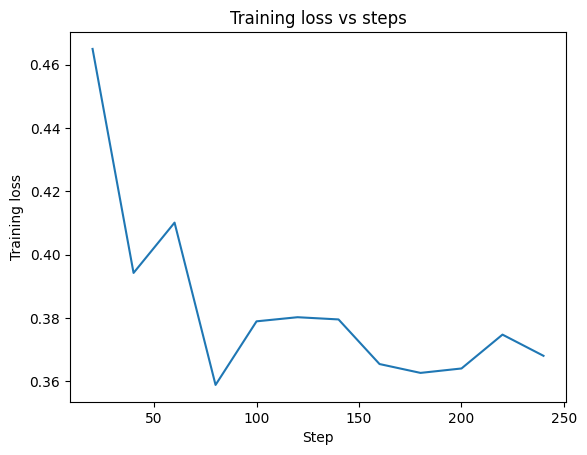

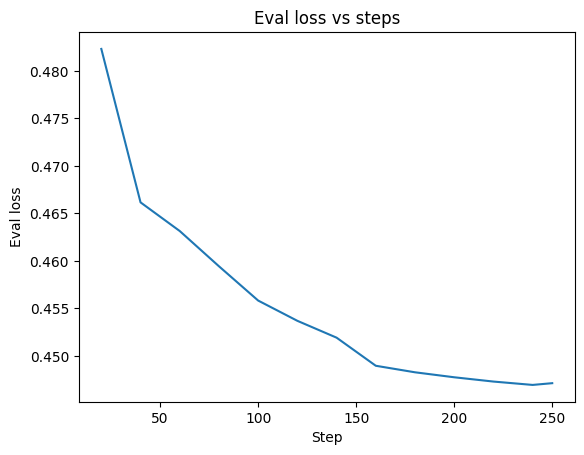

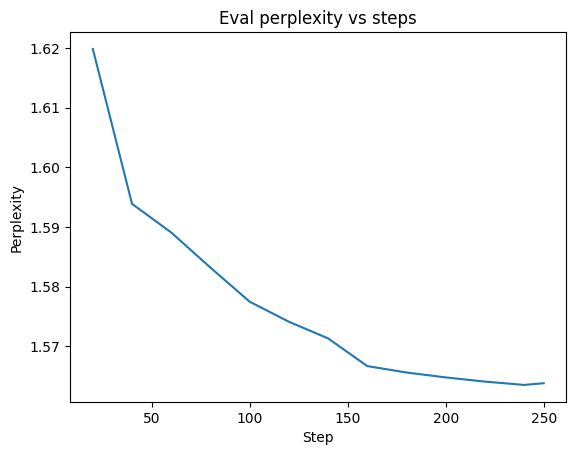

In [18]:
import math
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(trainer.state.log_history)

# Separate views
train_logs = hist[hist["loss"].notna()][["step","loss","learning_rate"]].copy()
eval_logs  = hist[hist["eval_loss"].notna()][["step","eval_loss"]].copy()
eval_logs["perplexity"] = eval_logs["eval_loss"].apply(lambda x: math.exp(x) if x < 20 else float("inf"))

display(train_logs.head())
display(eval_logs.head())

# ---- Plot 1: training loss vs steps ----
plt.figure()
plt.plot(train_logs["step"], train_logs["loss"])
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.title("Training loss vs steps")
plt.show()

# ---- Plot 2: eval loss vs steps ----
plt.figure()
plt.plot(eval_logs["step"], eval_logs["eval_loss"])
plt.xlabel("Step")
plt.ylabel("Eval loss")
plt.title("Eval loss vs steps")
plt.show()

# ---- Plot 3: eval perplexity vs steps ----
plt.figure()
plt.plot(eval_logs["step"], eval_logs["perplexity"])
plt.xlabel("Step")
plt.ylabel("Perplexity")
plt.title("Eval perplexity vs steps")
plt.show()

In [20]:
def extract_final_number(text):
    # GSM8K format expects ... '#### 24'
    m = re.search(r"####\s*(-?\d+(?:\.\d+)?)", text)
    return m.group(1) if m else None

In [21]:
def chat_generate(pipe, question, max_new_tokens=256, temperature=0.2):
    msgs = [
        {"role": "system", "content": "You are a careful math tutor. End with '#### <number>'."},
        {"role": "user", "content": question.strip()},
    ]
    out = pipe(
        msgs,
        do_sample=(temperature > 0),
        temperature=temperature,
        top_p=0.9,
        max_new_tokens=max_new_tokens,
        return_full_text=False,  # try to get only the completion when supported
    )

    # pipeline returns a list; first item has 'generated_text' or 'text'
    cand = out[0]
    gen = cand.get("generated_text") if isinstance(cand, dict) else None

    # Case A: 'generated_text' is already a string
    if isinstance(gen, str):
        return gen

    # Case B: 'generated_text' is a list of chat messages; pick last assistant content
    if isinstance(gen, list):
        for m in reversed(gen):
            if isinstance(m, dict) and m.get("role") == "assistant":
                return m.get("content", "")
        # Fallback: join anything that looks like text
        return " ".join(
            m.get("content", "") if isinstance(m, dict) else str(m) for m in gen
        )

    # Case C: some versions use 'text'
    if isinstance(cand, dict) and "text" in cand:
        return cand["text"]

    # Ultimate fallback
    return str(cand)

In [22]:
base_pipe = pipeline(
    "text-generation",
    model=AutoModelForCausalLM.from_pretrained(MODEL_ID, device_map="auto", torch_dtype="auto"),
    tokenizer=tokenizer
)

Device set to use cuda:0


In [23]:
ft_model = AutoModelForCausalLM.from_pretrained(MODEL_ID, device_map="auto", torch_dtype="auto")
ft_model = PeftModel.from_pretrained(ft_model, OUT_DIR)
ft_pipe = pipeline("text-generation", model=ft_model, tokenizer=tokenizer)

Device set to use cuda:0


In [24]:
def eval_subset(pipe, dataset, n=50):
    n = min(n, len(dataset))
    correct = 0
    for i in range(n):
        q = dataset[i]["messages"][0]["content"]
        gold_full = dataset[i]["messages"][1]["content"]
        gold = extract_final_number(gold_full)
        pred_text = chat_generate(pipe, q, temperature=0.0)  # now always str
        pred = extract_final_number(pred_text)
        correct += int(gold is not None and pred == gold)
    return correct, n, correct / n if n > 0 else 0.0

In [25]:
print("\nEvaluating on a small subset...")
base_correct, base_total, base_acc = eval_subset(base_pipe, eval_ds, n=50)
ft_correct,   ft_total,   ft_acc   = eval_subset(ft_pipe,   eval_ds, n=50)

print(f"Base: {base_correct}/{base_total} = {base_acc:.3f}")
print(f"FT  : {ft_correct}/{ft_total} = {ft_acc:.3f}")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Evaluating on a small subset...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Base: 4/50 = 0.080
FT  : 21/50 = 0.420
